In [1]:
!pip install wandb

In [2]:
!pip install cvxpy

In [3]:
import wandb
import torch
import numpy as np
import networkx as nx
import agent as fba
import env as fbe
from PIL import Image
from tqdm import tqdm
from matplotlib import cm
from torch.utils.data import DataLoader

In [24]:
def main(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    gossip = torch.tensor(gossip_numpy, device=config['device'])

    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    pseudo_loss = 0
    regret = []
    pseudo_regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        sub_optimal = sum(actions==1)
        #print(actions)
        sub_count = torch.count_nonzero(actions, dim = 0)[1].item()
        pseudo_loss +=sub_count/config['n_agents']
        pseudo_regret.append(pseudo_loss)
                          
        # compute cumulative losses
        cumu_loss += torch.matmul(
            torch.mean(L_t, dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret, pseudo_regret


In [25]:
#FedEXP3 - Large M without shuffling; theorem 8 
itr = 20
regret_list = []
pseudo_regret_list = []
for i in np.arange(itr):
    config = dict(
    proj = 'FedExp3',
    env = 'HalfActBandit-5',
    network = 'PATH',
    gossip = 'MaxDegree',
    n_agents = 30,
    n_arms = 2,                 
    horizon = 2000,                  
    lr = .1,
    gamma = 0.01,
    seed = 0,
    WANDB = False,
    jobtype = 'test'
)
    regret_fedexp3, pseudo_regret_fedexp3 = main(config)
    regret_list.append(regret_fedexp3)
    pseudo_regret_list.append(pseudo_regret_fedexp3)

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 2237.79it/s]


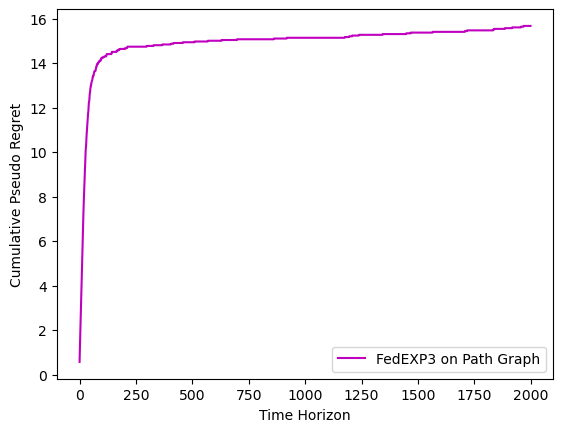

In [27]:
regret_fedexp3 = np.mean(pseudo_regret_list, 0)
x_axis = np.arange(len(regret_fedexp3))
plot_data_o = np.transpose(np.array(regret_fedexp3)).reshape((2000,1))
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)

plt.plot(x_axis,plot_data_o,  label='FedEXP3 on Path Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Pseudo Regret')

plt.legend()
plt.show()

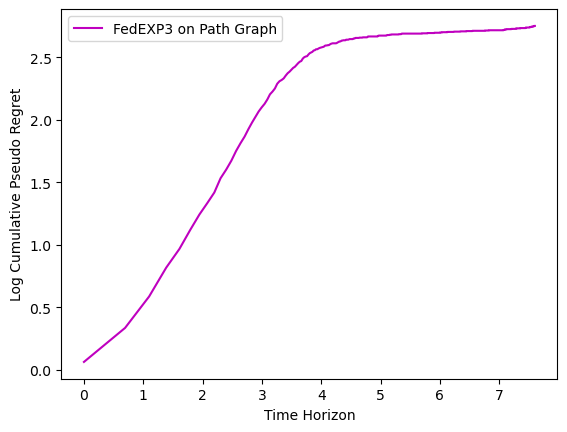

array([2.05321008])

In [29]:
plt.plot(np.log(x_axis[1:]),np.log(plot_data_o[1:]),  label='FedEXP3 on Path Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Log Cumulative Pseudo Regret')

plt.legend()
plt.show()

X= np.reshape(np.log(x_axis[1:]),(len(x_axis[1:]),-1))
y = np.log(plot_data_o[1:])
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.coef_
reg.intercept_

In [36]:
import statsmodels.api as sm
X_train_lm = sm.add_constant(X)
lm = sm.OLS(y, X_train_lm).fit()
print(lm.summary())

#since M = T^{1/3}
#the total order in T is as follows
#order = x1 + 1/3*const
order = reg.coef_ + 1/3*reg.intercept_
diff = np.abs(order - 2/3)/(2/3)
print(order.item(),diff.item())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     1441.
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          6.94e-238
Time:                        23:46:50   Log-Likelihood:                 1508.2
No. Observations:                1999   AIC:                            -3012.
Df Residuals:                    1997   BIC:                            -3001.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0532      0.017    119.695      0.0

In [37]:
#problem instance 
T = 2000
eta = 8*(2000**(-2/15))
M = int(2000**(2/15)) 
d = eta*M/8
epsilon = np.sqrt(1/eta)*(M**2)*(T**(-1/3))

In [38]:
M, d, epsilon

(2, 0.72592652049981, 0.18631178740808066)

In [40]:
#shuffling bandits 
import os
import datetime
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
class HomoBandit_0(Dataset):
    def __init__(self, n_epochs, n_agents, n_arms, rng) -> None:
        super().__init__()
        global_means = [1/2, 1/2]
        L = np.array(
            [rng.binomial(1, p, size=(n_epochs, n_agents)) for p in global_means], 
            dtype=np.float32
        )
        self.data = np.transpose(L, (1, 2, 0))
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

    def cumloss_of_best_arm(self):
        true_loss = np.mean(self.data, axis=1)
        cum_losses = np.cumsum(true_loss, axis=0)
        best_arm = np.argmin(cum_losses[-1,])
        return cum_losses[:,best_arm]
        

class StoShuActBandit(HomoBandit_0):
    def __init__(self, n_epochs, n_agents, n_arms, activate_size, rng) -> None:
        super().__init__(n_epochs, n_agents, n_arms, rng)
        period = int(d)+1
        print(period)
        for t in range(n_epochs):
            if t%period== 0:
                special_idx = rng.choice(
                int((n_agents)/4)+1,
                size=1,
                replace=False
            )
                means = [1/2,1/2+epsilon]
                L_1 = np.array(
            [rng.binomial(1, p, size=(period, 1)) for p in means], 
            dtype=np.float32
        )
                self.data[t:(t+period),special_idx,:] = np.transpose(L_1, (1, 2, 0))
            non_selected_idx = rng.choice(
                n_agents,
                size=n_agents - activate_size,
                replace=False
            )
            self.data[t,non_selected_idx,:] = 0

In [41]:
def main_shuffle(config):
    use_cuda = torch.cuda.is_available()
    config['device'] = torch.device("cuda" if use_cuda else "cpu")
    rng = torch.Generator(device=config['device'])
    rng.manual_seed(config['seed'])

    # Create dataset
    env = config['env'].split('-')[0]
    if env == "HomoBandit":
        train_data = fbe.HomoBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            np.random.default_rng(
                int(config['env'].split('-')[-1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfActBandit':
        train_data = fbe.StoActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'HalfFixActBandit':
        train_data = fbe.FixActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    elif env == 'StoShuActBandit':
        train_data = StoShuActBandit(
            config['horizon'], 
            config['n_agents'], 
            config['n_arms'],
            config['n_agents']//2,               # activation size
            np.random.default_rng(
                int(config['env'].split('-')[1]) # seed of the loss tensor
            )
        )
    else:
        raise NotImplementedError("The "+env+" environment has not been implemented.")
    train_loader = DataLoader(
        train_data,
        batch_size=1, 
        shuffle=False
    )
    # compute cumulative loss of the best arm in hindsight
    best_cumu_loss = train_data.cumloss_of_best_arm()

    # Specify communcation network
    network = config['network'].split('-')[0]
    if network == 'COMPLETE':
        graph = nx.complete_graph(config['n_agents'])
    elif network == 'PATH':
        graph = nx.path_graph(config['n_agents'])
    elif network == 'NONE':
        graph = nx.from_numpy_array(
            np.zeros([
                config['n_agents'], config['n_agents']
            ])
        )
    elif network == 'GRID':
        graph = nx.grid_graph([
            int(np.sqrt(config['n_agents'])),
            int(np.sqrt(config['n_agents']))
        ])
    elif network == 'RGG':
        r = float(config['network'].split('-')[1])
        # threshold = np.sqrt(np.log(config['n_agents']) ** 1.1 / config['n_agents'])
        # if r  < threshold:
        #     raise ValueError(
        #         'Please choose r >= ' + str(threshold)
        #     )
        graph = nx.random_geometric_graph(
            config['n_agents'], 
            r,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    elif network == 'ER':
        p = float(config['network'].split('-')[1])
        graph = nx.fast_gnp_random_graph(
            config['n_agents'], 
            p,
            seed=int(
                config['network'].split('-')[-1]
            )
        )
    else:
        raise NotImplementedError("The "+config['network']+" network has not been implemented.")
    comm_net = fba.CommNet(graph)

    # Specify the gossip
    if config['network'] == 'NONE':
        gossip_numpy = np.eye(config['n_agents'])
        spectral_gap = 0
    elif config['gossip'] == 'MaxDegree':
        gossip_numpy, spectral_gap = comm_net.max_deg_gossip(spectral_gap=True)
    elif config['gossip'] == 'Fast-SDP':
        gossip_numpy, spectral_gap = comm_net.fast_gossip('SDP', spectral_gap=True)
    else:
        raise NotImplementedError("The "+config['gossip']+" mechanism has not been implemented.")
    gossip = torch.tensor(gossip_numpy, device=config['device'])

    # Create FedExp3
    agent = fba.FedExp3(
        config['n_agents'],
        config['n_arms'],
        gossip, 
        config['lr'],
        expr_scheduler=fba.cube_root_scheduler(config['gamma']),
        device=config['device']
    )

    
    # Initialize WANDB
    if config['WANDB']:
        wandb.init(
            project=config['proj'], 
            reinit=True, 
            config=config, 
            job_type=config['jobtype']
        )
        prob_imgs = []

    cumu_loss = 0
    pseudo_loss = 0
    regret = []
    pseudo_regret = []
    rounds = len(train_loader)
    for i, loss_matrix in tqdm(enumerate(train_loader), total=rounds):
        L_t = torch.squeeze(loss_matrix, 0).to(config['device'])
        # make actions
        actions, probs = agent.action(rng)
        
        sub_count = torch.count_nonzero(actions, dim = 0)[1].item()
        pseudo_loss +=sub_count/config['n_agents']
        pseudo_regret.append(pseudo_loss)
        # compute cumulative losses
        #print(L_t.shape, torch.transpose(actions.float(), 1, 0).shape)
        cumu_loss += torch.matmul(
            torch.mean(L_t, dim=0),
            torch.transpose(actions.float(), 1, 0)
        )
        # update
        agent.update(L_t, actions, probs)
        
        regret.append(torch.mean(cumu_loss).item() - best_cumu_loss[i])
        #print(regret)

        # logging
        if config['WANDB']:
            wandb.log({
                'mean': torch.mean(cumu_loss).item() - best_cumu_loss[i],
                'max': torch.max(cumu_loss).item()- best_cumu_loss[i],
            })
            if i % (config['horizon'] // 10) == 0:
                prob_imgs.append(
                    wandb.Image(
                        Image.fromarray(
                            np.uint8(cm.viridis(probs.tolist())*255)
                        )
                    )
                )

    if config['WANDB']:
        wandb.log({"visual_probs": prob_imgs})
        wandb.log({'mixing_time': spectral_gap ** (-1/3)})
        wandb.finish()
    
    return regret, pseudo_regret


In [42]:
#FedEXP3 - smaller M with shuffling; theorem 9 
itr = 50
regret_list = []
for i in np.arange(itr):
    config = dict(
    proj = 'FedExp3',
    env = 'StoShuActBandit-5',
    network = 'PATH',
    gossip = 'MaxDegree',
    n_agents = 10,
    n_arms = 2,                 
    horizon = 2000,                  
    lr = .1,
    gamma = 0.01,
    seed = 0,
    WANDB = False,
    jobtype = 'test'
)
    placeholder, regret_fedexp3 = main_shuffle(config)
    regret_list.append(regret_fedexp3)

1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4022.16it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3709.65it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3464.91it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3532.37it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3837.97it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4148.48it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3674.40it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4058.91it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4118.83it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4058.88it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3561.14it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3628.24it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3645.52it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4107.32it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4065.24it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4097.76it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3725.65it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3868.83it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4108.14it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3016.29it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 2928.57it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3153.20it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3502.14it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3215.53it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4298.88it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3653.56it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3715.75it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3716.62it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3912.56it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3460.45it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3227.62it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3621.07it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3998.69it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4120.19it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3983.84it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3373.44it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4394.59it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4232.05it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3893.08it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 3908.68it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4123.13it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4341.59it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4240.98it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4407.17it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4333.89it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4002.70it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4379.97it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4303.47it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4202.18it/s]


1


100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 4404.95it/s]


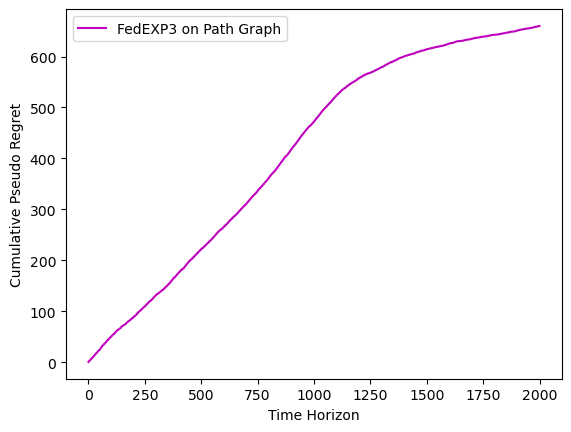

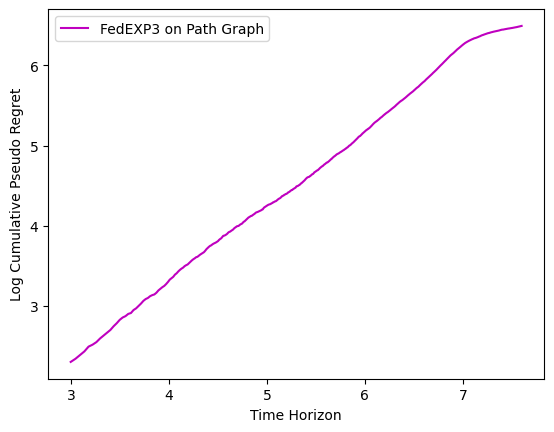

[[0.92740067]] [-0.36329935]


In [44]:
regret_fedexp3 = np.mean(regret_list, 0)
x_axis = np.arange(len(regret_fedexp3))
plot_data_o = np.transpose(np.array(regret_fedexp3)).reshape((2000,1))
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)

plt.plot(x_axis,plot_data_o,  label='FedEXP3 on Path Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Pseudo Regret')

plt.legend()
plt.show()



plt.plot(np.log(x_axis[20:]),np.log(plot_data_o[20:]),  label='FedEXP3 on Path Graph',color='m')


plt.xlabel('Time Horizon')
plt.ylabel('Log Cumulative Pseudo Regret')

plt.legend()
plt.show()

X= np.reshape(np.log(x_axis[20:]),(len(x_axis[20:]),-1))
y = np.log(plot_data_o[20:])
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
print(reg.coef_,reg.intercept_)



In [45]:
#since M is small and we treat it as constant 
#the total order in T is as follows
#order = x1 
order = reg.coef_ 
diff = np.abs(order - 2/3)/(2/3)
print(order.item(),diff.item())

0.927400674156996 0.39110101123549407


In [46]:
import statsmodels.api as sm
X_train_lm = sm.add_constant(X)
lm = sm.OLS(y, X_train_lm).fit()
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.918e+05
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        23:48:42   Log-Likelihood:                 2105.7
No. Observations:                1980   AIC:                            -4207.
Df Residuals:                    1978   BIC:                            -4196.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3633      0.014    -25.586      0.0

In [47]:
#total order is as follow
order = reg.coef_ + 2/15*reg.intercept_

In [48]:
order

array([[0.87896076]])